# DSAIT4335 Recommender Systems
# Final Project

In this project, you will work to build different recommendation models and evaluate the effectiveness of these models through offline experiments. The dataset used for the experiments is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/. For more details, check the project description on Brightspace.

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   RecSysProject/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── codes.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Note** Be sure to run all cells such that the submitted file contains the output of each cell.

**Note** Feel free to add cells if you need more for answering a question.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your group number: example, group10 -> 10.ipynb.

# Setup

In [1]:

!pip install transformers torch  # For BERT
!pip install -r requirements.txt
# you can refer https://huggingface.co/docs/transformers/en/model_doc/bert for various versions of the pre-trained model BERT


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# For BERT embeddings (install: pip install transformers torch)
print("Check the status of BERT installation:")

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    BERT_AVAILABLE = True
    print("BERT libraries loaded successfully!")
    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    print(f"Using device: {device}")
except ImportError:
    BERT_AVAILABLE = False
    print("BERT libraries not available. Install with: pip install transformers torch")

Check the status of BERT installation:
BERT libraries loaded successfully!
Using device: cuda


In [1]:
import os.path
from typing import Any
from numpy import floating
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300 # for clearer plots in the notebook
plt.rcParams['savefig.dpi'] = 300

from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import re
import time, math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(10)

print("Libraries imported successfully!")

Libraries imported successfully!


# Load dataset

In [2]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv('data/training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv('data/test.txt', sep='\t', names=columns_name)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')

The training data:


,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


The shape of the training data: (80000, 4)
--------------------------------
The test data:


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


The shape of the test data: (20000, 4)


In [3]:
movies = pd.read_csv('data/movies.txt',names=['item_id','title','genres','description'],sep='\t')
movies.head()

,item_id,title,genres,description
0,1,Toy Story (1995),"Animation, Children's, Comedy","A group of sentient toys, who pretend to be li..."
1,2,GoldenEye (1995),"Action, Adventure, Thriller","In 1986, MI6 agents James Bond and Alec Trevel..."
2,3,Four Rooms (1995),Thriller,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,4,Get Shorty (1995),"Action, Comedy, Drama",Chili Palmer is a Miami-based loan shark and m...
4,5,Copycat (1995),"Crime, Drama, Thriller",After giving a guest lecture on criminal psych...


# Task 1) Implementation of different recommendation models as well as a hybrid model combining those recommendation models

In [8]:
from ast import List
from recommendation_algorithms.hybrid_recommender import HybridRecommender
from recommendation_algorithms.matrix_factorization import MatrixFactorizationSGD
from recommendation_algorithms.bayesian_probabilistic_ranking import BayesianProbabilisticRanking
from recommendation_algorithms.item_knn import ItemKNN
from recommendation_algorithms.user_knn import UserKNN

# TODO add others
item_knn = ItemKNN(k=8)
user_knn = UserKNN(k=8)
matrix_factorization = MatrixFactorizationSGD()
bpr = BayesianProbabilisticRanking()
rating_recommenders = [matrix_factorization, item_knn, user_knn]
ranking_recommenders = [matrix_factorization, bpr, item_knn, user_knn]
max_k = 10 # Recommendation list size
ranking_weights = {
	'Matrix Factorization': 0.25,
	'Bayesian Probabilistic Ranking': 0.25,
	'Item KNN': 0.25,
	'User KNN': 0.25,
}
hybrid_recommender = HybridRecommender(train_data, rating_recommenders, ranking_recommenders, max_k, ranking_weights, True)

Started training hybrid recommender on 943 users and 1650 items...
Training individual models...
  Loaded predictions for Matrix Factorization from checkpoint.
Finished training individual models.
Started linear regression...
[INFO] Visualization saved to: plots\linear_regression_rating_2025-10-25_17-13-44.png
Finished rating linear regression, weights are:
  Matrix Factorization: 1.0064251219379128
Precomputing predictions...
Finished computing predictions, model is ready to use.


In [17]:
user_id = 12
item_id = 2
# predicted_score = hybrid_recommender.predict_score(user_id, item_id)
# actual_score = train_data.loc[((train_data['user_id'] == user_id) & (train_data['item_id'] == item_id)), 'rating'].values[0]
# print(f'Predicted score {predicted_score} for user {user_id} and item {item_id}, actual score: {actual_score}.')

predicted_ranking = hybrid_recommender.predict_ranking(user_id, max_k)
user_df = train_data.loc[(train_data['user_id'] == user_id), ['item_id', 'rating']]
actual_ranking = (
        user_df.nlargest(max_k, 'rating')
        .apply(lambda row: (row['item_id'], row['rating']), axis=1)
        .tolist()
)
print(f"Predicted & actual ranking for user {user_id}")
for i in range(len(predicted_ranking)):
    print(f"  {i + 1}: predicted: {predicted_ranking[i]} & actual: {actual_ranking[i]}")

Predicted & actual ranking for user 12
  1: predicted: (169.0, 2.04675061048853) & actual: (4, 5)
  2: predicted: (64.0, 1.5009403017981806) & actual: (69, 5)
  3: predicted: (174.0, 1.4737886923553705) & actual: (88, 5)
  4: predicted: (313.0, 1.4581417319824816) & actual: (98, 5)
  5: predicted: (173.0, 1.4577209608831918) & actual: (161, 5)
  6: predicted: (12.0, 1.4542368113017816) & actual: (174, 5)
  7: predicted: (272.0, 1.4535505704551945) & actual: (216, 5)
  8: predicted: (50.0, 1.4319056428968764) & actual: (238, 5)
  9: predicted: (408.0, 1.4278526031084255) & actual: (242, 5)
  10: predicted: (22.0, 1.4267876525919148) & actual: (591, 5)


#### Test BPR Out 

In [ ]:
from recommendation_algorithms.bayesian_probabilistic_ranking import BayesianProbabilisticRanking

bpr = BayesianProbabilisticRanking()
bpr.train(train_data)   

#### User-based Collaborative Filtering

In [ ]:
from recommendation_algorithms.user_knn import UserKNN

In [5]:
u_knn = UserKNN(2)

df = pd.DataFrame({
    'user_id': [1, 2, 3, 1, 2, 3, 1, 2, 3, 4, 4],
    'item_id': [1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 2],
    'rating':  [5, 4, 3, 3, 4, 3, 2, 4, 5, 5, 3]
})

u_knn.train(df)

4it [00:00, 697.74it/s]


In [6]:
u_knn.predict_score(4, 3)

users_that_rated_i: 
[1, 2, 3]
sim_matrix_masked: 
          1    2         3    4
1  0.000000  0.0 -0.755929  1.0
2  0.000000  0.0  0.000000  0.0
3 -0.755929  0.0  0.000000  0.0
sims: 
2    0.000000
1   -0.755929
Name: 3, dtype: float64
ni 
[2 1]
rvi 
[4 2]
rv 
[4.         3.33333333]


np.float64(5.333333333333334)

### Item-based Collaborative Filtering

In [48]:
from recommendation_algorithms.item_knn import ItemKNN

In [49]:
i_knn = ItemKNN(2)

df = pd.DataFrame({
    'user_id': [1, 2, 3, 1, 2, 3, 1, 2, 3, 4, 4],
    'item_id': [1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 2],
    'rating':  [5, 4, 3, 3, 4, 3, 2, 4, 5, 5, 3]
})

i_knn.train(df)




3it [00:00, 1528.35it/s]


In [50]:
i_knn.predict_score(4, 3)

np.float64(3.954941986653667)

# Task 2) Experiments for both rating prediction and ranking tasks, and conducting offline evaluation

## Code

In [4]:
## RATING TESTING
from recommendation_algorithms.matrix_factorization import MatrixFactorizationSGD

k=10

mf = MatrixFactorizationSGD()
mf.train(train_data)

# training data predictions
print('Getting ratings...')
mf.calculate_all_predictions(train_data)
print('Getting rankings...')
mf.calculate_all_rankings(k, train_data)

mf.save_predictions_to_file()
mf.save_rankings_to_file()

Getting ratings...
Getting rankings...


100%|██████████| 943/943 [00:03<00:00, 264.14it/s]


In [6]:
# Test data - rankings
def get_ranking_test_data(test_data: pd.DataFrame, k: int = 10) -> dict:
    """
    Create ground truth ranking series dict from test data for ranking evaluation.
    :param test_data: pd.DataFrame with columns=['user_id', 'item_id', 'rating']
    :param k: cut-off for ranking
    :return: dict where keys are user ids and values are pd.Series with index=item_id and values=rating
    """
    users = test_data['user_id'].unique().tolist()
    user_rankings = {
        user: test_data[test_data['user_id'] == user][['item_id', 'rating']]
        .sort_values(by='rating', ascending=False)
        .head(k)
        .set_index('item_id')['rating']
        for user in users
    }
    return user_rankings

# creates ranking series dict
user_rankings_test = get_ranking_test_data(test_data)


## Evaluation scripts

The evaluation scripts load from saved results to allow for batch processing of different models and baselines.

### Rating task

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300 # TODO - remove imports for final

prediction_filepaths = { # filepaths to the saved predictions from different models
    'MF': 'model_checkpoints/matrix_factorization_git/predictions.csv',
}

def load_rating_predictions(file_path: str) -> pd.DataFrame:
    """
    Load predictions from a CSV file.

    :param file_path: path to the CSV file - assumes saved with columns=['user_id', 'item_id', 'predicted_score']
    :return: pd.DataFrame with columns=['user_id', 'item_id', 'predicted_rating']
    """
    predictions = pd.read_csv(file_path)
    predictions = predictions.rename(columns={'user_id': 'user_id', 'item_id': 'item_id', 'predicted_score': 'pred_rating'})
    return predictions

def load_all_rating_predictions(filepaths: dict) -> dict:
    """
    Load predictions from multiple CSV files.

    :param filepaths: dictionary where keys are model names and values are file paths
    :return: dictionary where keys are model names and values are pd.DataFrames with predictions
    """
    all_predictions = {}
    for model_name, file_path in filepaths.items():
        all_predictions[model_name] = load_rating_predictions(file_path)
    return all_predictions


In [7]:
d = load_all_rating_predictions(prediction_filepaths)
d

{'MF':          user_id  item_id  pred_rating
 0              1        1     4.807027
 1              1        2     3.148489
 2              1        3     3.319832
 3              1        4     3.977035
 4              1        5     3.240906
 ...          ...      ...          ...
 1555945      943     1679     3.406237
 1555946      943     1680     3.051879
 1555947      943      907     3.302043
 1555948      943     1681     3.205747
 1555949      943     1682     3.199535
 
 [1555950 rows x 3 columns]}

In [8]:
# EVALUATION functions
from sklearn.metrics import root_mean_squared_error

def evaluate_rating(ground_truth: list[float], predictions: list[float]) -> float:
    """
    Evaluation function for one model for rating prediction task - RMSE. Takes two lists of rating values as input and returns RMSE and MSE. Assumes that the two lists are aligned (i.e., the i-th element in each list corresponds to the same user-item pair).

    :param ground_truth: list of actual ratings
    :param predictions:  list of predicted ratings
    :return: float
    """
    return root_mean_squared_error(ground_truth, predictions)

def evaluate_rating_all(rating_prediction_dict: dict, test_data: pd.DataFrame) -> dict:
    """
    Evaluate a baseline or model against the test data for rating prediction task - RMSE for all models.
    :param rating_prediction_dict: dict of model/baseline predictions {model_name: pd.DataFrame} with columns=['user_id', 'item_id', 'pred_rating']
    :param test_data: pd.DataFrame with columns=['user_id', 'item_id', 'rating']
    :return:
    """
    res_dict = {}
    print(f'Evaluating rating predictions for all models...')
    for i, df in tqdm(rating_prediction_dict.items()):
        df2 = df.merge(test_data[['user_id','item_id','rating']], on=['user_id','item_id'])
        rmse = evaluate_rating(df2['rating'].tolist(), df2['pred_rating'].tolist())
        print(f'- {i}: RMSE = {rmse:.4f}')
        res_dict[i] = rmse
    # TODO - save
    return res_dict

res_dict = evaluate_rating_all(d, test_data)

Evaluating rating predictions for all models...


100%|██████████| 1/1 [00:00<00:00, 13.99it/s]

- MF: RMSE = 0.9575


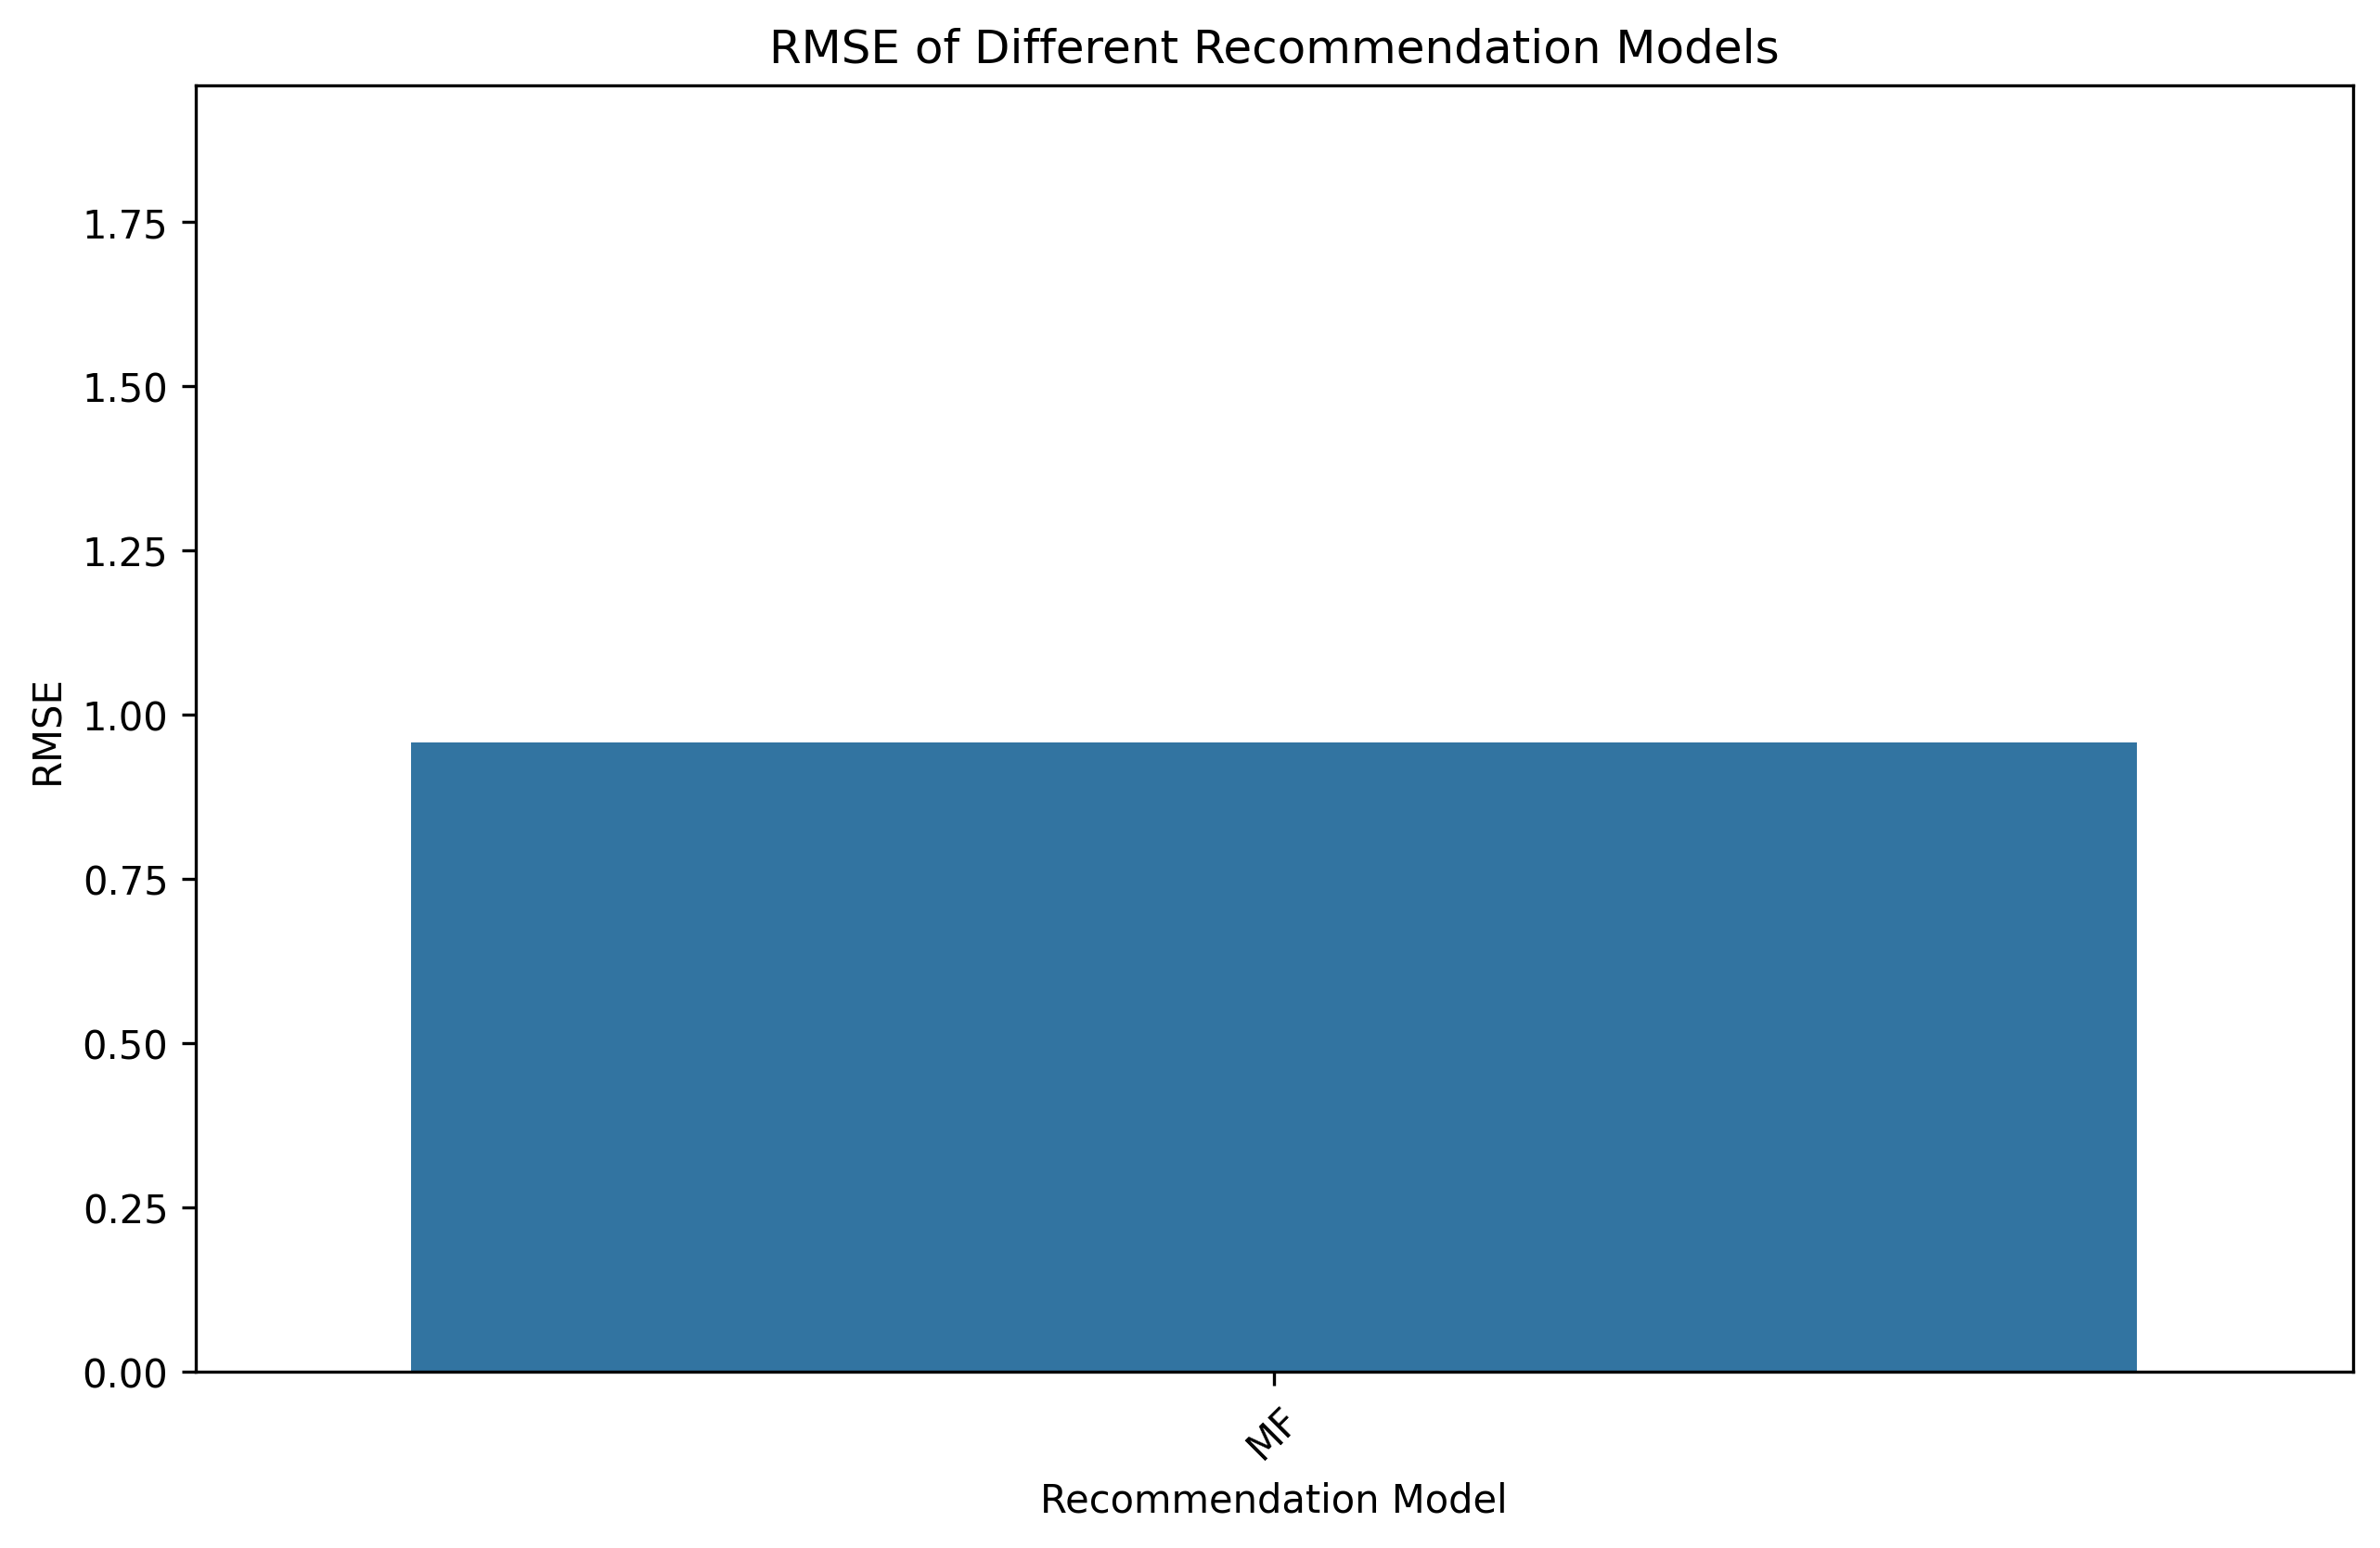

In [9]:
# VISUALISATION

# results_rating = { # debugging data
#     'content-based' : 1.2,
#     'user-based CF' : 1.5,
#     'item-based CF' : 1.3,
#     'matrix factorisation' : 0.9,
#     'hybrid' : 0.8,
# }

def plot_rating_results(results: dict):
    """
    Plot RMSE results for different recommendation models.

    :param results: dictionary where keys are model names and values are RMSE scores
    """
    models = list(results.keys())
    rmse_scores = list(results.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=rmse_scores)
    plt.title('RMSE of Different Recommendation Models')
    plt.xlabel('Recommendation Model')
    plt.ylabel('RMSE')
    plt.ylim(0, max(rmse_scores) + 1)
    plt.xticks(rotation=45)  # readability
    plt.show()

plot_rating_results(res_dict)

### Ranking task

In [7]:
# Loading data in
import json
import os

ranking_prediction_filepaths = { # filepaths to the saved predictions from different models
    'MF': 'model_checkpoints/matrix_factorization/rankings/',
}

def load_model_ranking_predictions(folder_path: str) -> dict:
    """
    Load ranking predictions from a CSV file for all users.

    :param folder_path: path to the folder containing the rankings and mapping file
    :return: dictionary where keys are user IDs and values are ordered pd.Series with index=item_id and values=predicted_score
    """
    mapping_file = json.loads(open(os.path.join(folder_path, 'user_ranking_file_map.json'), 'r').read())
    user_dict = {}

    for user_id, file in mapping_file.items():
        predictions = pd.read_csv(file)
        p = predictions.set_index('item_id')['predicted_score']
        user_dict[int(user_id)] = p

    return user_dict

def load_all_ranking_predictions(filepaths: dict) -> dict:
    """
    Load ranking predictions from multiple CSV files.
    :param filepaths: dictionary where keys are model names and values are folder paths
    :return: ditionary where keys are model names and values are dictionaries { user_id: pd.Series with ranking predictions }
    """
    all_predictions = {}
    for i, d in filepaths.items():
        all_predictions[i] = load_model_ranking_predictions(d)
    return all_predictions

ranking_predictions = load_all_ranking_predictions(ranking_prediction_filepaths)

In [8]:
# Evaluation ranking task

def ndcg(ground_truth: list, rec_list: list, k = 10) -> float:
    """
    Calculate Normalized Discounted Cumulative Gain (NDCG) for a single user.
    :param ground_truth: list of relevant item ids
    :param rec_list: ranked list of recommended item ids
    :param k: cut off for NDCG calculation
    :return:
    """
    if k > len(rec_list):
        k = len(rec_list)
    dcg = 0.0
    for i in range(k):
        numerator = 1 if rec_list[i] in ground_truth else 0
        denominator = np.log2(i + 2)
        dcg += numerator / denominator
    ideal_len = min(k, len(ground_truth))
    if ideal_len == 0:
        return 0.0
    else:
        IDCG = sum(1.0 / np.log2(i + 2) for i in range(ideal_len))
        return dcg / IDCG


def evaluate_ranking(ground_truth: list[pd.Series], rec_list: list[pd.Series], k=10) -> tuple[
    floating[Any], floating[Any], floating[Any]]:
    """
    Calculate Precision, Recall, and NDCG for ranking task.

    Assume that items in rec_list are relevant (rel = 1) and items not in rec_list are non-relevant (rel = 0).

    :param ground_truth: lists of pd.Series of item ids that are relevant
    :param rec_list: list of pd.Series of recommended top-k item ids - index=item_ids, values=rating
    :param k: cut-off for ndcg (may change to be for P and R as well) - TODO
    :return:
    """
    # Compute Precision & Recall
    gt_items = [set(gt.index.values) for gt in ground_truth]
    rec_items = [set(rl.index.values) for rl in rec_list]
    len_intersections = np.array([len(set(gt).intersection(rl)) for rl, gt in zip(rec_items, gt_items)])
    len_rls = np.array([len(rl) for rl in rec_items])
    len_gts = np.array([len(gt) for gt in gt_items])

    p = np.nanmean(100 * len_intersections / len_rls)  # precision
    r = np.nanmean(100 * len_intersections / len_gts)  # recall

    # Compute NDCG
    ndcgs = [ndcg(list(gt), list(rl), k) for rl, gt in zip(rec_items, gt_items)]
    ndcg_mean = np.nanmean(ndcgs)

    return p, r, ndcg_mean

def evaluate_ranking_all(prediction_dict: dict, test_data: dict, k=10, save_path: str = None) -> dict:
    """
    Evaluate a baseline or model against the test data for ranking task - Precision, Recall, NDCG for all models.
    :param save_path: full file path to save results to, if any
    :param prediction_dict: { model : { user_id: pd.Series with ranking predictions } }
    :param test_data: { user_id: pd.Series with ground truth ratings }
    :param k:
    :return:
    """
    results = {}
    users = test_data.keys()
    print('Evaluating ranking predictions for all models...')

    for model_name, user_predictions in tqdm(prediction_dict.items()):
        ground_truth = []
        rec_list = []
        for user in users:
            if user in user_predictions:
                ground_truth.append(test_data[user])
                rec_list.append(user_predictions[user].nlargest(k))
        precision, recall, ndcg_mean = evaluate_ranking(ground_truth, rec_list, k)
        results[model_name] = [precision, recall, ndcg_mean]
        print(f'- {model_name}: Precision = {precision:.2f}%, Recall = {recall:.2f}%, NDCG = {ndcg_mean:.4f}')

    if save_path:
        df = pd.DataFrame.from_dict(results, orient='index', columns=['precision', 'recall', 'ndcg']).reset_index(names='model')
        df.to_csv(save_path, index=False)
    return results

In [9]:
# DEBUG - example use

# ground_truth = [[1, 2, 3], [2, 3, 4], [1, 4]]
# rec_list = [[2, 3, 5], [1, 2, 3], [4, 5, 6]]
#
# ground_truth = [pd.Series(np.ones(len(gt)), index=gt) for gt in ground_truth]
# rec_list = [pd.Series(np.ones(len(rl)), index=rl) for rl in rec_list]
#
# precision, recall, ndcg_mean = evaluate_ranking(ground_truth, rec_list, k=3)
# print(f'Precision: {precision:.2f}%, Recall: {recall:.2f}%, NDCG: {ndcg_mean:.4f}')
#
# models = {'m1' : {'u1' : rec_list[0], 'u2' : rec_list[1], 'u3' : rec_list[2]}}
# test = {'u1' : ground_truth[0], 'u2' : ground_truth[1], 'u3' : ground_truth[2]}
#
# results = evaluate_ranking_all(models, test, k=3)

results = evaluate_ranking_all(ranking_predictions, user_rankings_test, k=3)


Evaluating ranking predictions for all models...


100%|██████████| 1/1 [00:00<00:00, 14.43it/s]

- MF: Precision = 5.30%, Recall = 1.67%, NDCG = 0.0520


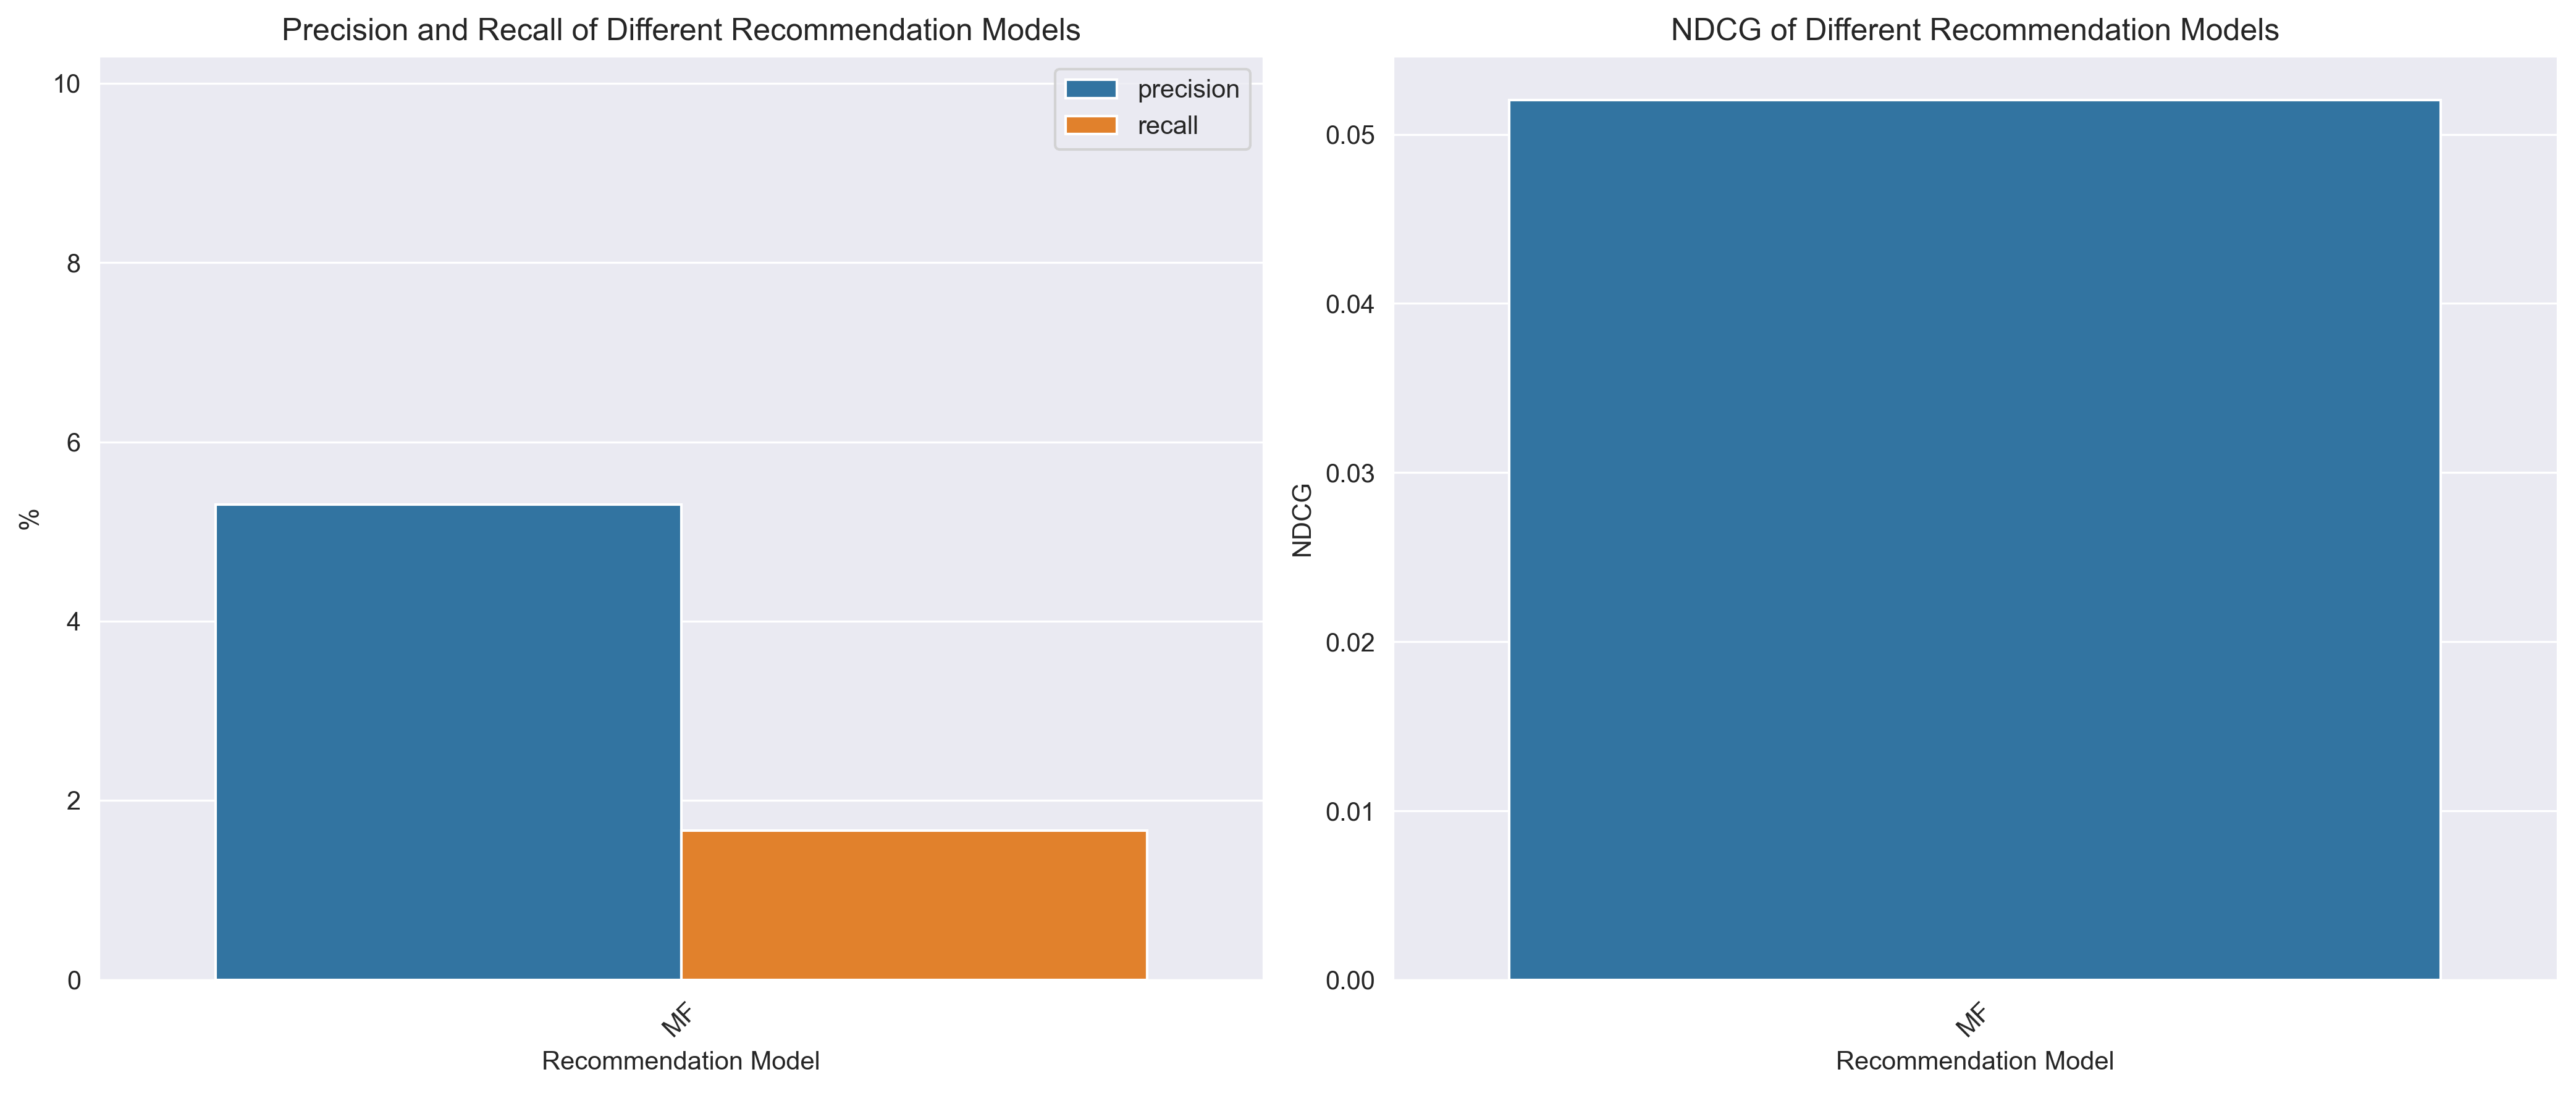

In [10]:
# VISUALISATION

# results_ranking = {  # [precision, recall, ndcg] -- DEBUG DATA
#     'content-based' : [20.0, 15.0, 0.1],
#     'user-based CF' : [10.0, 20.0, 0.6],
#     'item-based CF' : [05.0, 45.0, 0.8],
#     'matrix factorisation' : [30.0, 35.0, 0.4],
#     'hybrid' : [20.0, 40.0, 0.2],
# }


def visualise_ranking_results(results: dict, tight: bool = False):
    """
    Plot Precision and Recall, and NDCG results for different recommendation models.

    :param results: dictionary where keys are model names and values are lists of [precision, recall, ndcg]
    :param tight: whether to display the two plots (Precision & Recall, NDCG) side by side
    """
    df = pd.DataFrame.from_dict(results, orient='index', columns=['precision', 'recall', 'ndcg']).reset_index().rename(columns={'index': 'model'})
    df_melt = df.melt(id_vars='model', value_vars=['precision', 'recall'], var_name='metric', value_name='value')

    if not tight:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_melt, x='model', y='value', hue='metric', palette=['tab:blue', 'tab:orange'], errorbar=None)
        plt.title('Precision and Recall of Different Recommendation Models')
        plt.xlabel('Recommendation Model')
        plt.ylabel('%')
        plt.xticks(rotation=45)  # readability
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='model', y='ndcg', errorbar=None)
        plt.title('NDCG of Different Recommendation Models')
        plt.xlabel('Recommendation Model')
        plt.ylabel('NDCG')
        plt.xticks(rotation=45)

    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        # Left - grouped Precision & Recall
        sns.barplot(data=df_melt, x='model', y='value', hue='metric',
                    palette=['tab:blue', 'tab:orange'], errorbar=None, ax=axes[0])
        axes[0].set_title('Precision and Recall of Different Recommendation Models')
        axes[0].set_xlabel('Recommendation Model')
        axes[0].set_ylabel('%')
        axes[0].set_ylim(0, df_melt['value'].max() + 5)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].legend(title=None)

        # Right - NDCG
        sns.barplot(data=df, x='model', y='ndcg', errorbar=None, ax=axes[1])
        axes[1].set_title('NDCG of Different Recommendation Models')
        axes[1].set_xlabel('Recommendation Model')
        axes[1].set_ylabel('NDCG')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
    plt.show()

visualise_ranking_results(results, tight=True)

# Task 3) Implement baselines for both rating prediction and ranking tasks, and perform experiments with those baselines

## Code

In [ ]:
%%sql


## Evaluation

You should be able to use the evaluation functions defined in Task 2 for evaluating the baselines, even in one big batch! The functions available are (pass is mainly written for my editor):

```python
def evaluate_rating_all(rating_prediction_dict: dict, test_data: pd.DataFrame) -> dict: pass
    # Takes {model_name: pd.DataFrame} with columns=['user_id', 'item_id', 'pred_rating']

def evaluate_ranking_all(prediction_dict: dict, test_data: dict, k=10, save_path: str = None) -> dict: pass
    # Takes { model : { user_id: pd.Series(index=item_id, values=predicted_rating) } }
```

# Task 4) Analysis of recommendation models. Analyzing the coefficients of hybrid model and the success of recommendation models for different users' groups. 

# Task 5) Evaluation of beyond accuracy

## Diversity - ILD

- intra-list diversity - ILD - average pairwise distance
$$
ILD(L) = \frac{1}{|L|(|L|-1)} \sum_{i,j \in L}dist(i,j)
$$
- $dist(i,j)$ - distance function of how different $i$ and $j$ are -- genre difference
-
	- eg, embedding distance, categorical distance

In [14]:
def diversity(rec_list: pd.Series, dist_func, movies: pd.DataFrame) -> float:
    """
    Calculate intra-list diversity (ILD) for a given recommendation list using a specified distance function.
    :param rec_list: top-k recommended item ids
    :param dist_func: function taking two item ids and movie data, and returning a distance value
    :return:
    """
    if len(rec_list) <= 1:
        return 0.0
    L = len(rec_list)
    frac = 1 / (L * (L - 1))
    total_dist = np.sum([dist_func(i,j, movies) for i in rec_list.index.to_list() for j in rec_list.index.to_list()])
    return frac * total_dist


def genre_distance(item1, item2, movies):
    """
    Genre distance using Jaccard distance.
    :param item1: item id 1
    :param item2: item id 2
    :param movies: movie data
    :return:
    """
    i1_genres = set(movies.at[item1, 'genres'].split(','))
    i2_genres = set(movies.at[item2, 'genres'].split(','))
    intersection = len(i1_genres.intersection(i2_genres))
    union = len(i1_genres.union(i2_genres))
    if union == 0:
        return 0.0
    return 1 - intersection / union


div = diversity(ranking_predictions['MF'][1], genre_distance, movies)
div

np.float64(0.9175132275132277)

\[Discussion]

## Novelty - surprisal - runs
- **self-information** - surprisal - measures how “surprising” an item is, based on its popularity
$$
novelty(i) = -\log_{2} pop(i)
$$

- $pop(i)$ - popularity of item $i$ - percentage of interactions on item $i$ = $\frac{num\_interactions\_on\_i}{total\_num\_interactions}$
  - from training data only?

In [15]:
def popularity_matrix(train_data: pd.DataFrame) -> pd.Series:
    """
    Calculate the popularity of each item in the training data.
    :param train_data: training data
    :return: pd.Series with item ids as index and popularity as values
    """
    total_interactions = len(train_data)
    counts = train_data['item_id'].value_counts()
    popularity = counts / total_interactions
    return popularity

def novelty(rec_list: pd.Series, train_data: pd.DataFrame, weighting_scheme:str = 'uniform') -> float:
    """
    Calculate the novelty / surprisal of the items in a recommendation list
    :param rec_list: pd.Series of recommended item ids, columns=['rating'], index=item ids
    :param train_data: training data
    :param weighting_scheme: 'uniform' or 'log' - how to weight the novelty of items in the list
    :return: novelty score
    """

    popularity = train_data['item_id'].value_counts(normalize=True)
    surprisal = -np.log2(popularity)

    # Find the weightings for the averaging
    if weighting_scheme == 'uniform':
        weights = np.ones(len(rec_list)) / len(rec_list)
    elif weighting_scheme == 'log':
        ranks = np.arange(1, len(rec_list) + 1)
        weights = 1 / np.log2(ranks + 1)  # TODO - check!
        weights /= np.sum(weights)
    else:
        raise ValueError("weighting_scheme must be 'uniform' or 'log'")

    surprisals = np.array([surprisal.loc[item] for item in rec_list.index.tolist()])
    novelty_score = np.sum(weights * surprisals)
    return novelty_score

nov = novelty(ranking_predictions['MF'][1], train_data, 'uniform')
nov

np.float64(8.182432765151976)

\[Discussion]

## Calibration - DOESN'T WORK - TODO - FIX

**Calibration metric** - Kullback-Leibler divergence (lower = better)
$$
\displaylines{
MC_{KL}(p,q) = KL(p||q) = \sum_{g} p(g|u) \log \frac{p(g|u)}{q(g|u)} \\
p(g|u) = \frac{\sum_{i\in \mathcal{H}}w_{u,i} \times p(g|i)}{\sum_{i \in \mathcal{H}} w_{u,i}} \\
q(g|u) = \frac{\sum_{i\in \mathcal{L}}w_{r(i)} \times p(g|i)}{\sum_{i \in \mathcal{L}} w_{r(i)}}
}
$$

- $p(g|i)$ - genre-distribution of each movie - categorisation of item
- $p(g|u)$ - distribution of genres $g$ in user $u$'s profile (based on training data)
    - $\mathcal{H}$ - interaction history
    - $w_{u,i}$ - weight of item $i$	- how recently played, playing duration, rating value, ...
- $q(g|u)$ - distribution of genres $g$ in the recommendation list for
    - $\mathcal{L}$ - recommended items
    - $w_{r(i)}$ - weight of item $i$ at rank $r(i)$ - weighting scheme used in ranking metrics - EG, MRR, nDCG
- to avoid division by zero - $\tilde{q}(g|u) = (1-\alpha) \cdot q(g|u) + \alpha \cdot p(g|u)$ with small $\alpha > 0$, s.t. $q \approx\tilde{q}$

In [16]:
def genre_distribution(movies: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate genre distribution for each movie.
    :param movies: [pd.DataFrame] containing movie metadata with columns=['item_id','title','genres','description']
    :return: pd.dataframe with all genres as columns, item id's as index, and p(g|i) as values
    """
    mov_genres = movies[['item_id', 'genres']].copy()
    mov_genres['genres'] = mov_genres['genres'].apply(lambda x: x.split(',')) # make the genres a list
    item_ids = mov_genres['item_id'].unique()
    # find all the genres present in the dataset
    all_genres = set()
    for genres in mov_genres['genres']:
        all_genres.update(genres)
    all_genres = list(all_genres)

    # calculate the distributions
    genre_dist = pd.DataFrame(np.zeros((len(item_ids), len(all_genres))), columns=all_genres, index=item_ids)
    for _, row in mov_genres.iterrows():
        item_id = row['item_id']
        genres = row['genres']
        genre_count = len(genres)
        for genre in genres:
            genre_dist.at[item_id, genre] = 1 / genre_count  # uniform distribution over genres
    return genre_dist

genre_distributions = genre_distribution(movies)
display(genre_distributions.head())

,Documentary,War,Action,War,Film-Noir,Crime,Mystery,Fantasy,Crime,Film-Noir,...,Horror,Comedy,unknown,Drama,Animation,Romance,Animation,Comedy,Fantasy,Mystery
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.333333,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0
2,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.333333,0.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,...,0.0,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0


In [17]:
def get_interaction_history(user_id, train_data: pd.DataFrame) ->  pd.Series:
    """
    Get interaction history of a user from training data.
    :param user_id: user id
    :param train_data: training data dataframe
    :return: list of item ids the user has interacted with
    """
    user_history = train_data[train_data['user_id'] == user_id]
    return user_history[['item_id', 'rating']].set_index('item_id')['rating']

u1_history = get_interaction_history(1, train_data)
u1_history

item_id
1      5
2      3
3      4
4      3
5      3
      ..
263    1
268    5
269    5
270    5
271    2
Name: rating, Length: 135, dtype: int64

In [18]:
def compute_genre_distribution_of_user(genre, genre_dist: pd.DataFrame, history: pd.Series):
    """
    Helper function for calibration metric - compute p(g|u) / q(g|u) for a given genre and user interaction history.

    Formulas are basically equivalent:  (idk equations work here)
    $$
    \displaylines{
        p(g|u) = \frac{\sum_{i\in \mathcal{H}}w_{u,i} \times p(g|i)}{\sum_{i \in \mathcal{H}} w_{u,i}} \\
        q(g|u) = \frac{\sum_{i\in \mathcal{L}}w_{r(i)} \times p(g|i)}{\sum_{i \in \mathcal{L}} w_{r(i)}}
    }
    $$

    p(g|u) = (w_{u,i} * p(g|i) for items in user history) / (sum of weights)
    q(g|u) = (w_{r(i) * p(g|i) for items in recommendation list) / (sum of weights)

    :param genre: genre to compute distribution for
    :param genre_dist: pd.DataFrame with all genres as columns, item id's as index, and p(g|i) as values
    :param history: pd.Series of item ids and ratings the user has interacted with, index=item ids, values=ratings
    :return:
    """
    pgi = [genre_dist.at[item, genre] for item in history.index.tolist()]
    ratings = history.values
    weighted_sum = np.sum(np.array(pgi) * np.array(ratings))
    return weighted_sum / np.sum(ratings)

user_genre_distribution = compute_genre_distribution_of_user('Action', genre_distributions, u1_history)
user_genre_distribution

np.float64(0.06140174379610999)

In [31]:
from scipy.special import rel_entr
def calibration(rec_list: pd.Series, user, train_data: pd.DataFrame, movie_data: pd.DataFrame) -> float:
    """
    Calculate calibration metric for a given recommendation list and user.
    :param rec_list: pd.Series of recommended item ids, columns=['rating'], index=item ids
    :param user: user for whom the recommendation was made
    :param train_data: training data
    :param movie_data:
    :return:
    """
    a = 0.001  # small alpha to avoid division by zero
    genre_dist = genre_distribution(movie_data) # p(g|i) - should work
    genres = genre_dist.columns.tolist()

    # pgu - genre distribution in user profile
    user_history = get_interaction_history(user, train_data) # H - works
    pgu = np.array([compute_genre_distribution_of_user(g, genre_dist, user_history) for g in genres]) # p(g|u) - should work

    # qgu - genre distribution in recommendation list
    qgu = np.array([compute_genre_distribution_of_user(g, genre_dist, rec_list) for g in genres]) # q(g|u)

    mask = (pgu != 0) & (qgu != 0)
    res = np.sum(pgu[mask] * np.log(pgu[mask] / qgu[mask]))
    return res

cal = calibration(ranking_predictions['MF'][1], 1, train_data, movies)
cal
# it seems to run without errors, but not sure if the values are correct

np.float64(-0.1613728404254557)

\[Discussion]

## Fairness

Types:
- User-side - RecSys serve individual users/groups equally
    - Group Recommendation Unfairness - GRU
    - User Popularity Deviation - UPD
- Item-side - fair representation of items \<--
    - catalog coverage - fraction of items recommended at least once (need results for all rankings (item-user pairs))
    - equality of exposure - entropy, gini index
    - demographic parity - exposure to each group should be $\propto$ group size
    - disparate treatment - exposure to each group should be $\propto$ group utility / merit
    - disparate impact - exposure to each group should be according to expected group attention to group utility/merit

### User-side fairness

$$
\displaylines{
GRU(G_1, G_2, Q) = \left| \frac{1}{|G_1|} \sum_{i \in G_1} \mathcal{F} (Q_i) - \frac{1}{|G_2|} \sum_{i \in G_2} \mathcal{F}(Q_i) \right| \\
UPD(u) = dist(P(R_u), P(L_u))
}
$$

- $\mathcal{F}(Q_i)$ - recommendation quality for user $u_i$, invoking a metric such as NDCG@K or F1 score
- $P(R_u)$ - popularity distribution of items in user $u$'s recommendation list
- $P(L_u)$ - popularity distribution of items in user $u$'s interaction history

In [37]:
def group_rec_unfairness(group1: list, group2: list, metric: str, rank_scores: pd.DataFrame) -> float:
    """
    Calculate Group Recommendation Unfairness (GRU) between two user groups, given a quality metric.
    :param group1: list of user ids in group 1
    :param group2: list of user ids in group 2
    :param metric: metric to use - ['nDCG', 'Precision', 'Recall', ...] - should match the column names in rank_scores
    :param rank_scores: scores of ranking tasks
    :return: GRU value as a float
    """
    g1_size = len(group1)
    g2_size = len(group2)
    if g1_size == 0 or g2_size == 0:
        return 0.0  # cannot compare a group w/ no users

    g1_avg = np.mean(rank_scores.at[group1, metric]) / g1_size
    g2_avg = np.mean(rank_scores.at[group2, metric]) / g2_size
    return g1_avg - g2_avg

group_rec_unfairness([], [], 'nDCG', pd.DataFrame())  # TODO - test

In [ ]:
def user_popularity_bias(user_id, rec_list: pd.Series, train_data: pd.DataFrame, ) -> float:
    item_popularity = popularity_matrix(train_data)
    user_history = get_interaction_history(user_id, train_data)
    p_ru = item_popularity.loc[rec_list.index.tolist()]
    p_lu = item_popularity.loc[user_history.index.tolist()]
    return np.mean(p_ru) - np.mean(p_lu)

u = user_popularity_bias(1, ranking_predictions['MF'][1], train_data)  # TODO - test
u

### Item-side fairness

In [ ]:
def catalog_coverage(rec_lists: list[pd.Series], movie_data: pd.DataFrame) -> float:
    total_no_movies = movie_data['item_id'].nunique()
    if total_no_movies == 0:
        return 0.0
    recommended_items = set()
    for rec_list in rec_lists:
        recommended_items.update(rec_list.index.tolist())
    no_recommended_items = len(recommended_items)
    return no_recommended_items / total_no_movies

In [ ]:
def equality_of_exposure(rec_lists: list[pd.Series], movie_data: pd.DataFrame) -> float: # TODO - go over
    total_no_movies = movie_data['item_id'].nunique()
    if total_no_movies == 0:
        return 0.0
    exposure_counts = pd.Series(0, index=movie_data['item_id'].tolist())
    for rec_list in rec_lists:
        for item in rec_list.index.tolist():
            exposure_counts.at[item] += 1
    exposure_probs = exposure_counts / exposure_counts.sum()
    gini_index = 1 - 2 * np.sum(exposure_probs.cumsum() * (1 / total_no_movies))
    return gini_index

Exposure:
$$
\text{Exposure}(G_k) = \frac{1}{|G_k|} \sum_{i \in G_k} \frac{1}{\log_2 (1 + pos(i))}
$$
 ^ unsure how to implement with worth

In [ ]:
def exposure(group: list):

    pass